In [3]:
# user defined functions

import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats
from scipy.signal import butter, filtfilt
from pykalman import KalmanFilter

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [4]:
dir='/home/gadfly/DataAnalysis/data/'

In [5]:
df=pd.read_hdf(dir+'DesertDataOct/Run4.h5')

In [39]:
new_alt=df.alt-np.mean(df.alt)


Text(0, 0.5, 'z movement, m')

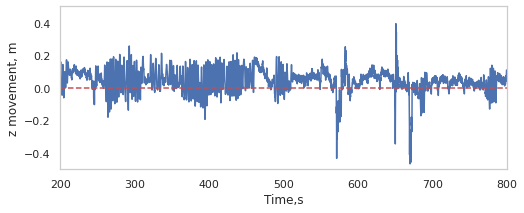

In [46]:
f,ax=plt.subplots(1,1,figsize=(8,3))
ax.plot(df.time,new_alt)
ax.grid(False)
ax.set_xlim(200,800)
ax.set_ylim(-0.5,0.5)
ax.axhline(y=0, color='r', linestyle='--')

mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':6},
                            smart_bounds=True,
                            yticks=[-0.5,0.5],
                            xticks=[200,800],
                            linewidth=0.5)
ax.set_xticklabels([], rotation=90)


ax.set_xlabel('600 secs')
ax.xaxis.set_label_coords(0.5, -0.1)



ax.set_xlabel('Time,s')
ax.set_ylabel('z movement, m')

In [ ]:
dt = df.master_time[1]-df.master_time[0]

position_z = [0]
for i in range(1,len(df)):
    # Integrate velocity to obtain position
    position_z.append(((df.imu_linear_acc_z[i] + df.imu_linear_acc_z[i-1]) / 2 * dt) * dt)
    

In [4]:
def normalize_array(arr, min_range, max_range):
    min_val = np.min(arr)
    max_val = np.max(arr)

    # Scale the array to the range [0, 1]
    normalized_arr = (arr - min_val) / (max_val - min_val)

    # Scale the array to the desired output range [min_range, max_range]
    scaled_arr = normalized_arr * (max_range - min_range) + min_range

    return scaled_arr


min_range = min(position_z)
max_range = max(position_z)
position_z_gps = normalize_array(df.alt, 0, 1)
position_z_imu = normalize_array(position_z,0,1)

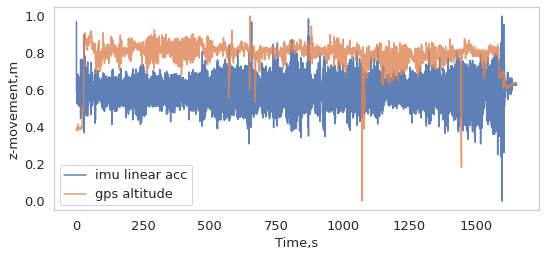

In [5]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax.plot(df.time,position_z_imu, alpha=0.9,label='imu linear acc')
ax.plot(df.time,position_z_gps,alpha=0.8, label='gps altitude')
ax.grid(False)
ax.set_xlabel('Time,s')
ax.set_ylabel('z-movement,m')
ax.legend()
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 13)
# f.savefig('../../Figure/zmovement.jpeg', dpi=300, bbox_inches = "tight")

In [6]:
n_timesteps = len(position_z_imu)
n_dim_state = 1  # Only the z position
n_dim_obs = 2    # Two z displacement measurements

# Define the system model
A = np.eye(n_dim_state)  # State transition matrix
H = np.eye(n_dim_obs, n_dim_state)  # Observation matrix

# Initialize the initial state mean and covariance
initial_state_mean = np.array([0])
initial_state_covariance = np.eye(n_dim_state)

# Set the process noise covariance and observation noise covariance
process_noise_covariance = 1e-4 * np.eye(n_dim_state)
observation_noise_covariance = np.eye(n_dim_obs)

kf = KalmanFilter(
    n_dim_state=n_dim_state,
    n_dim_obs=n_dim_obs,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    transition_matrices=A,
    observation_matrices=H,
    transition_covariance=process_noise_covariance,
    observation_covariance=observation_noise_covariance
)

# Combine the z displacement arrays into a single matrix
measurements = np.column_stack((position_z_gps, position_z_imu))


In [7]:
# kf = kf.em(measurements, n_iter=5)
# Apply the Kalman filter to estimate the best z measurements
state_means, state_covariances = kf.filter(measurements)
best_z_measurements = state_means[:, 0]

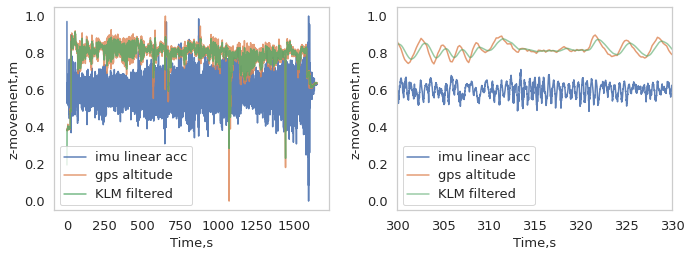

In [8]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
ax1.plot(df.time,position_z_imu, alpha=0.9,label='imu linear acc')
ax1.plot(df.time,position_z_gps,alpha=0.8, label='gps altitude')
ax1.plot(df.time,best_z_measurements,alpha=0.8,label='KLM filtered')
ax1.grid(False)
ax1.set_xlabel('Time,s')
ax1.set_ylabel('z-movement,m')
ax1.legend()


ax2.plot(df.time,position_z_imu, alpha=0.9,label='imu linear acc')
ax2.plot(df.time,position_z_gps,alpha=0.8, label='gps altitude')
ax2.plot(df.time,best_z_measurements,alpha=0.6,label='KLM filtered')
ax2.grid(False)
ax2.set_xlabel('Time,s')
ax2.set_ylabel('z-movement,m')
ax2.legend()

ax2.set_xlim(300,330)
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 13)
f.savefig('../../Figure/zklm.jpeg', dpi=300, bbox_inches = "tight")